In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [4]:
data = np.load('data.npy')
target = np.load('target.npy')
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).float()

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,1:]
train_target = target[train_idx,1] #target is 1=profitloss
test_data = data[test_idx,:,1:]
test_target = target[test_idx,1] #target is 1=profitloss

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [5]:
batch_size=50

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

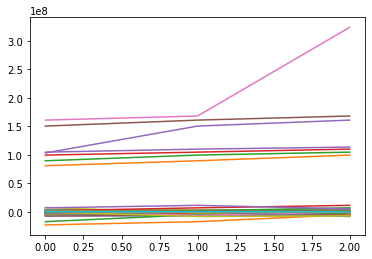

In [6]:
for i in range(100):
    plt.plot(data[i,:,1])
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=5,out_features=30),
                                   nn.ReLU(),
                                   nn.Linear(30,100),
                                   nn.ReLU(),
                                   nn.Linear(100,50)) 
        self.rnn = nn.LSTM(input_size=50,
                          hidden_size=100,
                          num_layers=5,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=300,out_features=500),
                                     nn.ReLU(),
                                     nn.Linear(500,250),
                                     nn.ReLU(),
                                     nn.Linear(250,100),
                                     nn.ReLU(),
                                     nn.Linear(100,25),
                                     nn.ReLU(),
                                     nn.Linear(25,2))

        
    def forward(self, x): #x = [batch_size,3,5]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,50]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,50]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,50]
        x1 = x1.unsqueeze(1) #[batch_size,1,50]
        x2 = x2.unsqueeze(1) #[batch_size,1,50]
        x3 = x3.unsqueeze(1) #[batch_size,1,50]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        x = torch.cat(temp,dim=1) #[batch_size,3,50]                        
                                            
        x,_ = self.rnn(x) #[batch_size,3,100]
        x = x.reshape(x.shape[0],-1) #[batch_size,300]
                       
        x = self.linearOut(x) #[batch_size,2]
        
#         x[1] = torch.abs(x[1])

        return x


In [8]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y)+sigma/1000)

In [9]:
model = Net()
model.to(device)
print(model)

Net(
  (linearIn): Sequential(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
  )
  (rnn): LSTM(50, 100, num_layers=5, batch_first=True)
  (linearOut): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=25, bias=True)
    (7): ReLU()
    (8): Linear(in_features=25, out_features=2, bias=True)
  )
)


In [10]:
lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
#Training loop
num_epochs = 20

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = cost(output[:,0],output[:,1], target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        
    #Comput the test accuracy
    test_error = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        test_error += cost(output[:,0],output[:,1],target)
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}\t test error: {test:.1f}".format(test=test_err, train=train_err))


train error: 1016348016640.0	 test error: 229272.6



train error: 279073.8	 test error: 110011.2



train error: 144955.0	 test error: 63766.5



train error: 86932.9	 test error: 41950.4



train error: 53074.5	 test error: 2263.7



train error: 2190.6	 test error: 864.3



train error: 1204.4	 test error: 596.2



train error: 868.9	 test error: 452.8



train error: 669.2	 test error: 355.0



train error: 849.3	 test error: 475.2



train error: 896.4	 test error: 190.0



train error: 285.4	 test error: 183.2



train error: 889.3	 test error: 234.5



train error: 273.4	 test error: 123.9



train error: 183.6	 test error: 123.3



train error: 266.4	 test error: 230.4



train error: 579.2	 test error: 434.0



train error: 1698.5	 test error: 383.3



train error: 706.1	 test error: 455.5



train error: 453.9	 test error: 123.3



In [16]:
print(data[1:2])
print(target[1:2])
temp =model(data[1:2])
print(temp)

tensor([[[  459022.5000,        0.0000,   565122.5000,   908095.0000,
          11582933.0000],
         [-2402584.5000,        0.0000,   482234.0000,   748957.5000,
           7560032.5000],
         [-3144909.0000,        0.0000,   203536.0000,   467537.5000,
           2855770.5000]]], device='cuda:0')
tensor([-52276.], device='cuda:0')
tensor([[ 9951146.0000, -2336042.2500]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [17]:
cost(temp[:,0],temp[:,1],target[:1])

tensor(2360.6665, device='cuda:0', grad_fn=<MeanBackward0>)